<IPython.core.display.Javascript object>


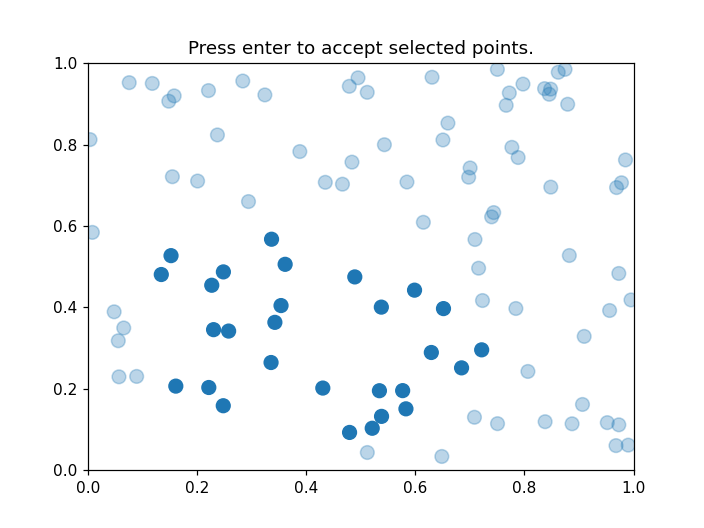

In [1]:
import numpy as np

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

%matplotlib notebook


class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # Fixing random state for reproducibility
    np.random.seed(19680801)

    data = np.random.rand(100, 2)

    subplot_kw = dict(xlim=(0, 1), ylim=(0, 1), autoscale_on=False)
    fig, ax = plt.subplots(subplot_kw=subplot_kw)

    pts = ax.scatter(data[:, 0], data[:, 1], s=80)
    selector = SelectFromCollection(ax, pts)

    def accept(event):
        if event.key == "enter":
            print("Selected points:")
            print(selector.xys[selector.ind])
            selector.disconnect()
            ax.set_title("")
            fig.canvas.draw()

    fig.canvas.mpl_connect("key_press_event", accept)
    ax.set_title("Press enter to accept selected points.")

    plt.show()